# Funcionamiento red sin reducción de dimensionalidad

In [2]:
using Flux
using Flux: train!
using DataFrames
using CSV
using SciMLSensitivity
using ComponentArrays, Optimization, OptimizationOptimJL, OptimizationFlux
using IterTools: ncycle
using Random
using StatsBase
using Plots
include("./Parameters.jl")
include("./UtilidadesSeñales.jl")

GetSignalsDataSet (generic function with 1 method)

In [2]:
rng = Random.seed!(1234)  # Set seed for reproducibility
path_read = "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/1-GeneracionDatos/Data/SignalHahn_TE_1_G_8.73e-7_forPCA.csv"

"C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/1-GeneracionDatos/Data/SignalHahn_TE_1_G_8.73e-7_forPCA.csv"

In [3]:
# Rango de tamaños medios de correlación en μm
lcms = 0.5:0.01:6
# Desviaciones estándar
sigmas = 0.01:0.01:1

parameters = zeros(length(lcms) * length(sigmas), 2)

# Obtenemos los parámetros de las señales
for i in 1:length(lcms)
    for j in 1:length(sigmas)
        parameters[(i - 1) * length(sigmas) + j, 1] = sigmas[j]
        parameters[(i - 1) * length(sigmas) + j, 2] = lcms[i]
    end
end

parameters = DataFrame(
    sigmas = parameters[:,1],
    lcms = parameters[:,2],
)

function SplitDataSets(n_samples, lcms, sigmas, train_ratio, val_ratio)

    # Generate the Cartesian product of lcms and sigmas
    pairs = [(lcm, sigma) for lcm in lcms, sigma in sigmas]

    lower_bound = first(pairs)
    upper_bound = last(pairs)
    middle_pairs = pairs[2:end-1]

    # Downsample the middle values
    downsampled_middle = sample(rng, middle_pairs, n_samples - 2, replace = false)

    # Combine lower, middle, and upper pairs
    downsampled_pairs = [lower_bound; downsampled_middle; upper_bound]

    # Shuffle the downsampled pairs
    shuffled_pairs = shuffle(rng, downsampled_pairs)

    n_total = length(shuffled_pairs)
    n_train = round(Int, train_ratio * n_total)
    n_val = round(Int, val_ratio * n_total)
    n_test = n_total - n_train - n_val  # Ensure all elements are used
    
    # Split the shuffled pairs
    train_set = shuffled_pairs[1:n_train]
    val_set = shuffled_pairs[n_train+1:n_train+n_val]
    test_set = shuffled_pairs[n_train+n_val+1:end]
    
    return train_set, val_set, test_set

end

SplitDataSets (generic function with 1 method)

* ID,Arq,Activ,Opt,PuntosUsados,Lambd,dp_rate,MSE_Train,MSE_Val,MSE_Test,NSeñales
* 60,"[20, 32, 64, 32, 16, 2]",relu,AdamW,20,0.0,0.0,7.564191764686257e-5,7.896960596553981e-5,7.733979145996273e-5,55100

In [4]:
NUMSIGNALS = 55100
id = 60
# División del dataset en entrenamiento, validación y test
train_set, val_set, test_set = SplitDataSets(NUMSIGNALS, lcms, sigmas, 0.8, 0.1)

([(4.26, 0.16), (3.64, 0.65), (2.97, 0.74), (5.23, 0.07), (4.41, 0.96), (1.45, 0.9), (0.85, 0.44), (5.18, 0.07), (3.99, 0.29), (2.53, 0.78)  …  (4.51, 0.69), (0.68, 0.16), (5.41, 0.26), (2.09, 0.11), (3.95, 0.24), (0.57, 0.06), (4.65, 0.34), (2.62, 0.14), (5.25, 0.19), (3.03, 0.04)], [(0.82, 0.57), (1.52, 0.7), (2.91, 0.26), (2.57, 0.41), (4.97, 0.01), (4.06, 0.5), (1.08, 0.12), (4.8, 0.55), (2.14, 0.73), (5.33, 0.87)  …  (2.54, 0.46), (2.18, 0.76), (4.61, 0.17), (1.71, 0.85), (2.22, 0.44), (1.2, 0.75), (3.39, 0.34), (2.39, 0.3), (4.89, 0.22), (2.49, 0.86)], [(1.48, 0.32), (1.77, 0.25), (3.17, 0.34), (5.98, 0.7), (2.04, 0.36), (5.61, 0.72), (5.79, 0.28), (1.95, 0.23), (2.01, 0.39), (5.8, 0.69)  …  (1.83, 0.78), (3.14, 0.48), (3.67, 0.21), (2.27, 0.94), (1.82, 0.43), (5.05, 0.09), (5.28, 0.09), (2.83, 0.96), (5.96, 0.39), (2.88, 0.28)])

In [5]:
# train_lcms = map(x -> x[1], train_set)
# train_sigmas = map(x -> x[2], train_set)

# val_lcms = map(x -> x[1], val_set)
# val_sigmas = map(x -> x[2], val_set)

# test_lcms = map(x -> x[1], test_set)
# test_sigmas = map(x -> x[2], test_set)

# Vamos a tomar un subconjunto de t para hacer el entrenamiento de la NODE para agilizar los tiempos de entrenamiento
muestreo_corto =  20 # Cada cuantos tiempos tomamos un timepo para entrenar la NODE
muestreo_largo = 10

# Esto da 60 tiempos 50 puntos desde 0 a 0.1 y 10 puntos desde 0.1 a 1
t_shortaux = t_short[1:muestreo_corto:end]
t_longaux = t_long[1:muestreo_largo:end]

t = vcat(t_shortaux, t_longaux);

In [6]:
# Obtenemos las señales con el dominio de tiempo reducido
signalsTrain = GetSignalsDataSet(path_read, parameters, train_sigmas, train_lcms, muestreo_corto, muestreo_largo, t)
signalsVal = GetSignalsDataSet(path_read, parameters, val_sigmas, val_lcms, muestreo_corto, muestreo_largo, t)
signalsTest = GetSignalsDataSet(path_read, parameters, test_sigmas, test_lcms, muestreo_corto, muestreo_largo, t)

5510×60 Matrix{Float32}:
 1.0  0.981205  0.909584  0.80677   0.702127  …  0.00238942   0.00191482
 1.0  0.977557  0.88382   0.743597  0.600467     3.70484f-5   2.54678f-5
 1.0  0.96982   0.810756  0.545408  0.299585     1.40017f-6   9.95669f-7
 1.0  0.967216  0.780589  0.463068  0.200449     0.000350041  0.000307261
 1.0  0.975568  0.864402  0.690174  0.517661     0.000374362  0.000295567
 1.0  0.967646  0.784807  0.474361  0.215832  …  0.000643153  0.000569701
 1.0  0.965957  0.768328  0.429363  0.150231     6.12983f-14  3.21492f-14
 1.0  0.97575   0.869019  0.705061  0.538255     2.58775f-6   1.62981f-6
 1.0  0.975951  0.866856  0.695982  0.527453     0.000875365  0.000712436
 1.0  0.96732   0.781727  0.466132  0.204211     0.00034688   0.000303924
 1.0  0.980349  0.890158  0.747122  0.613178  …  0.0694845    0.0653983
 1.0  0.973048  0.83108   0.595098  0.390029     0.0240631    0.0225734
 1.0  0.970436  0.81514   0.556811  0.321654     0.000200225  0.00016527
 ⋮                    

In [9]:
println(step_long)

5


In [6]:
n_usados = 20

idx_end = length(t)

n_usados_short = floor(Int, n_usados * 0.9)
n_usados_long = ceil(Int, n_usados * 0.1)

step_short = ceil(Int, 51 / n_usados_short)
step_long = ceil(Int, 9 / n_usados_long)

t_usados = t[1:step_short:51]
t_usados = vcat(t_usados, t[51:step_long:idx_end])

if t_usados[end] != t[end]
    push!(t_usados, t[end])
end

t_usados = unique(t_usados)
indexes_usados = [i for i in 1:length(t) if t[i] in t_usados]

20-element Vector{Int64}:
  1
  4
  7
 10
 13
 16
 19
 22
 25
 28
 31
 34
 37
 40
 43
 46
 49
 51
 56
 60

In [8]:
signalsTrainPuntos = Float32.(transpose(signalsTrain[:,indexes_usados]))
signalsValPuntos = Float32.(transpose(signalsVal[:,indexes_usados]))
signalsTestPuntos = Float32.(transpose(signalsTest[:,indexes_usados]))

dataParamsTrainY = zeros32(2, size(train_lcms, 1))
dataParamsValidY = zeros32(2, size(val_lcms, 1))
dataParamsTestY = zeros32(2, size(test_lcms, 1))

dataParamsTrainY[1, :] = train_lcms
dataParamsTrainY[2, :] = train_sigmas

dataParamsValidY[1, :] = val_lcms
dataParamsValidY[2, :] = val_sigmas

dataParamsTestY[1, :] = test_lcms
dataParamsTestY[2, :] = test_sigmas

5510-element Vector{Float64}:
 0.32
 0.25
 0.34
 0.7
 0.36
 0.72
 0.28
 0.23
 0.39
 0.69
 0.79
 0.93
 0.48
 ⋮
 0.31
 0.66
 0.78
 0.48
 0.21
 0.94
 0.43
 0.09
 0.09
 0.96
 0.39
 0.28

In [9]:
model = Flux.Chain(
    Flux.Dense(20, 32),
    Flux.Dense(32, 64, relu),
    Flux.Dense(64, 32, relu),
    Flux.Dense(32, 16, relu),
    Flux.Dense(16, 2, softplus)
)

Chain(
  Dense(20 => 32),                      # 672 parameters
  Dense(32 => 64, relu),                # 2_112 parameters
  Dense(64 => 32, relu),                # 2_080 parameters
  Dense(32 => 16, relu),                # 528 parameters
  Dense(16 => 2, softplus),             # 34 parameters
)                   # Total: 10 arrays, 5_426 parameters, 21.820 KiB.

In [10]:
# Creamos los dataloaders
dataTrain = Flux.DataLoader((signalsTrainPuntos, dataParamsTrainY), batchsize = n_usados, shuffle = false)
dataValid = Flux.DataLoader((signalsValPuntos, dataParamsValidY), batchsize = n_usados, shuffle = false)
dataTest = Flux.DataLoader((signalsTestPuntos, dataParamsTestY), batchsize = n_usados, shuffle = false)

276-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, batchsize=20)
  with first element:
  (20×20 Matrix{Float32}, 2×20 Matrix{Float32},)

In [69]:
signalsValPuntos

20×5510 Matrix{Float32}:
 1.0       1.0        1.0          …  1.0         1.0          1.0
 0.92141   0.772045   0.562488        0.630711    0.446728     0.648641
 0.817801  0.507989   0.0836084       0.18428     0.00677339   0.306645
 0.756728  0.420967   0.0189614       0.0780003   4.9672f-5    0.239881
 0.714305  0.374286   0.00760554      0.044775    3.64291f-6   0.208649
 0.681156  0.342275   0.00390873   …  0.0294259   7.05907f-7   0.188355
 0.653738  0.317992   0.00228596      0.0208368   2.07106f-7   0.173452
 0.630294  0.298536   0.0014495       0.0154881   7.63303f-8   0.161781
 0.609797  0.28239    0.000972526     0.0119189   3.25846f-8   0.152263
 0.591586  0.268655   0.000680656     0.00941738  1.54384f-8   0.14428
 0.575206  0.256752   0.000492388  …  0.00759775  7.91327f-9   0.137442
 0.560328  0.246288   0.000365838     0.00623486  4.31517f-9   0.13149
 0.546706  0.23698    0.000277893     0.00518953  2.47433f-9   0.12624
 0.534151  0.22862    0.000215069     0.0043717

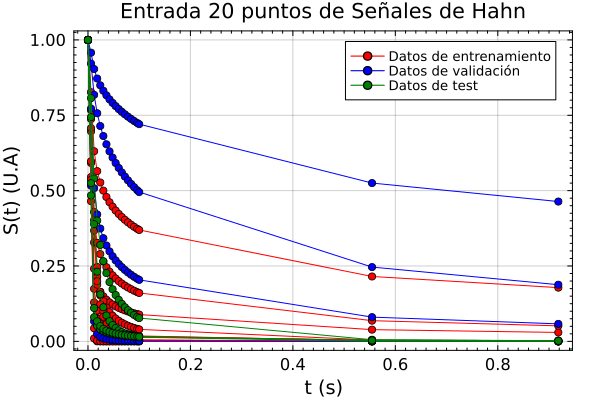

In [72]:
signalsTrainPuntos

# Graficamos los puntos de la señal que entran en la red

pl_inputnn = plot(t_usados, signalsTrainPuntos[:,1], label = "Datos de entrenamiento", xlabel = "t (s)", ylabel = "S(t) (U.A)", title = "Entrada 20 puntos de Señales de Hahn", color = "red", markershape = :circle, legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)

for i in 2:5000:size(signalsTrainPuntos, 2)
    plot!(pl_inputnn, t_usados, signalsTrainPuntos[:,i], label = "", color = "red", markershape = :circle)
end


plot!(pl_inputnn, t_usados, signalsValPuntos[:,1], label = "Datos de validación", color = "blue", markershape = :circle)

for i in 2:2000:size(signalsValPuntos, 2)
    plot!(pl_inputnn, t_usados, signalsValPuntos[:,i], label = "", color = "blue", markershape = :circle)
end

plot!(pl_inputnn, t_usados, signalsTestPuntos[:,1], label = "Datos de test", color = "green", markershape = :circle)

for i in 2:2000:size(signalsTestPuntos, 2)
    plot!(pl_inputnn, t_usados, signalsTestPuntos[:,i], label = "", color = "green", markershape = :circle)
end


display(pl_inputnn)

In [11]:
# L2 Penalty
pen_l2(x::AbstractArray) = sum(abs2, x) / 2

# Loss function
function loss(x, y)
    return Flux.mse(model(x), y)
end

loss (generic function with 1 method)

In [12]:
# Definimos una funcion de callback para ver el progreso del entrenamiento
history_loss_train = []
history_loss_val = []

global iter = 0
callback = function ()
    global iter += 1
    if iter % length(dataTrain) == 0
        epoch = iter ÷ length(dataTrain)
        push!(history_loss_train, loss(dataTrain.data[1], dataTrain.data[2]))
        push!(history_loss_val, loss(dataValid.data[1], dataValid.data[2]))
        
        if length(history_loss_val) > 1000 && epoch % 5000 == 0
            if history_loss_val[end] < history_loss_val[end - 2500]
                println("Saving model with validation loss $(history_loss_val[end]) at epoch $epoch")
                params_nn, re_nn = Flux.destructure(model)
                df_theta = DataFrame(reshape(params_nn, length(params_nn), 1), :auto)
                CSV.write("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/5-Simplificación/Arquitectura60/0$(id)_parameters_epoch_$(epoch).csv", df_theta)
            end
        end

        if epoch % 500 == 0
            actual_loss = loss(dataTrain.data[1], dataTrain.data[2])
            actual_val_loss = loss(dataValid.data[1], dataValid.data[2])
            println("Epoch $epoch || Loss = $actual_loss || Test Loss = $actual_val_loss")
        end
        GC.gc()
    end
end

η = 0.01
epochs = 10000
optim = AdamW(η)

for epoch in 1:epochs
    Flux.train!(loss, Flux.params(model, optim), dataTrain, optim, cb=callback)
    if epoch % 1000 == 0
        println("Reducing learning rate on plateau")
        η = η * 0.2
        optim = AdamW(η)
    end
end

Epoch 500 || Loss = 0.0036332544 || Test Loss = 0.0035851172
Epoch 1000 || Loss = 0.0014054485 || Test Loss = 0.0014063169
Reducing learning rate on plateau
Epoch 1500 || Loss = 0.00021543758 || Test Loss = 0.00021515727
Epoch 2000 || Loss = 0.0002765636 || Test Loss = 0.0002664564
Reducing learning rate on plateau
Epoch 2500 || Loss = 0.00023122322 || Test Loss = 0.00022929061
Epoch 3000 || Loss = 0.00023438736 || Test Loss = 0.00023125703
Reducing learning rate on plateau
Epoch 3500 || Loss = 0.00021281486 || Test Loss = 0.00021183312
Epoch 4000 || Loss = 0.0002097944 || Test Loss = 0.00020963437
Reducing learning rate on plateau
Epoch 4500 || Loss = 0.00020216104 || Test Loss = 0.00020461282
Saving model with validation loss 0.00020469754 at epoch 5000
Epoch 5000 || Loss = 0.00020100255 || Test Loss = 0.00020469754
Reducing learning rate on plateau
Epoch 5500 || Loss = 0.00019983968 || Test Loss = 0.00020384078
Epoch 6000 || Loss = 0.0001996547 || Test Loss = 0.00020365906
Reducing 

In [19]:
using Measures

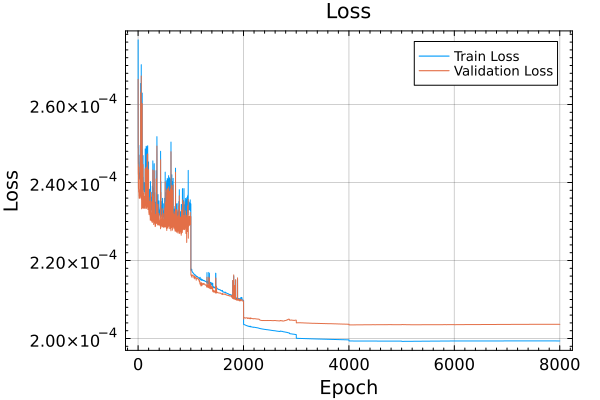

In [21]:
pl_losses = plot(history_loss_train[2000:end], label = "Train Loss", title = "Loss", xlabel = "Epoch", ylabel = "Loss", legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
plot!(pl_losses, history_loss_val[2000:end], label = "Validation Loss")

In [85]:
params_nn, re_nn = Flux.destructure(model)
df_theta = DataFrame(reshape(params_nn, length(params_nn), 1), :auto)
CSV.write("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/5-Simplificación/Arquitectura60/0$(id)_parameters_epoch_Final.csv", df_theta)

"C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/5-Simplificación/Arquitectura60/060_parameters_epoch_Final.csv"

In [86]:
losses = DataFrame(
    epoch = 1:epochs,
    train_loss = history_loss_train,
    val_loss = history_loss_val
)

CSV.write("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/5-Simplificación/Arquitectura60/0$(id)_losses.csv", losses)

"C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/5-Simplificación/Arquitectura60/060_losses.csv"

In [24]:
train_predictions = model(signalsTrainPuntos)
val_predictions = model(signalsValPuntos)
test_predictions = model(signalsTestPuntos)

2×5510 Matrix{Float32}:
 1.48158   1.77309  3.1683    6.00692   …  2.84116   5.96806   2.89673
 0.301431  0.25699  0.344769  0.721008     0.955042  0.441135  0.276005

In [25]:
# Root Mean Squared Error
function RMSE(predicted, real)
    return sqrt(sum((predicted .- real).^2) / length(predicted))
end

# Mean Absolute Error
function MAE(predicted, real)
    return sum(abs.(predicted .- real)) / length(predicted)
end

MAE (generic function with 1 method)

In [30]:
# Medidas de error globales
MAE_train = MAE(train_predictions, dataParamsTrainY)
RMAE_train = RMSE(train_predictions, dataParamsTrainY)
MAE_valid = MAE(val_predictions, dataParamsValidY)
RMAE_valid = RMSE(val_predictions, dataParamsValidY)


println("MAE Train: $MAE_train")
println("RMAE Train: $RMAE_train")

println("MAE Valid: $MAE_valid")
println("RMAE Valid: $RMAE_valid")

MAE Train: 0.010538262
RMAE Train: 0.014120208
MAE Valid: 0.010533418
RMAE Valid: 0.014270204


* Errores localmente

In [31]:
size(train_predictions)

(2, 44080)

In [98]:
# Medidas de error puntuales
N = length(train_predictions[1,:])
N_test = length(test_predictions[1,:])

MAE_scores = zeros(N)
MAE_test_scores = zeros(N_test)

RMSE_scores = zeros(N)
RMSE_test_scores = zeros(N_test)


for i in 1:N
    MAE_scores[i] = MAE(train_predictions[:,i], dataParamsTrainY[:,i])
    RMSE_scores[i] = RMSE(train_predictions[:,i], dataParamsTrainY[:,i])
end

for i in 1:N_test
    MAE_test_scores[i] = MAE(test_predictions[:,i], dataParamsTestY[:,i])
    RMSE_test_scores[i] = RMSE(test_predictions[:,i], dataParamsTestY[:,i])
end

In [77]:
# Distribucion de probabilidad log-normal que se puede agregar a la función costo de la red neuronal, lleva mucho tiempo de entrenamiento
function Pln(lcm, σ)
    return [(exp(-(log(lc) - log(lcm))^2 / (2σ^2))) / (lc * σ * sqrt(2π)) for lc in lcs]
end

Pln (generic function with 1 method)

In [78]:
using LaTeXStrings

El máximo RMAE en test es 0.06570228189229965 y se encuentra en la posición 2425
El mínimo RMAE en test es 0.0002450005558785051 y se encuentra en la posición 4489


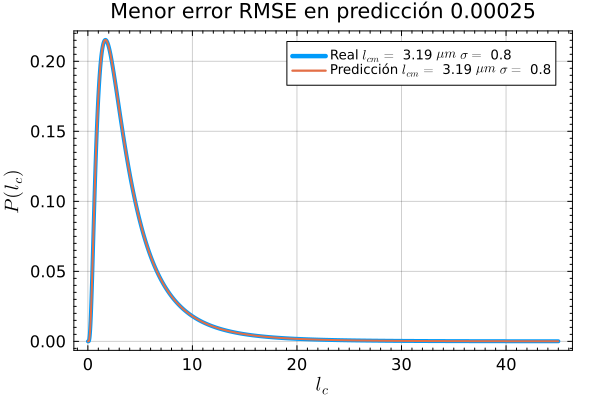

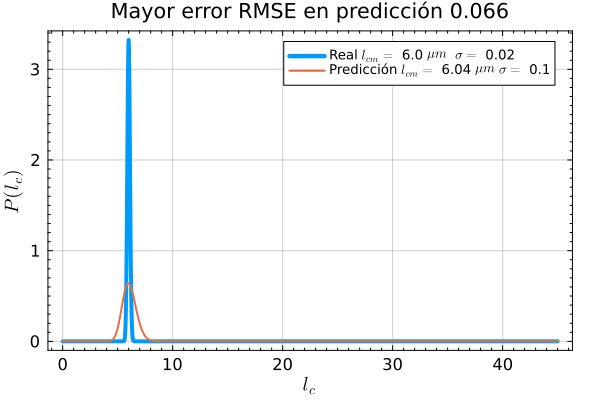

In [95]:
# Evaluamos la red neuronal con los datos de testeo
best = 0
worst = 0
for i in 1:N_test
    if minimum(RMSE_test_scores) == RMSE_test_scores[i]
        println("El mínimo RMAE en test es $(RMAE_test_scores[i]) y se encuentra en la posición $i")
        best = i
    end
    if maximum(RMSE_test_scores) == RMSE_test_scores[i]
        println("El máximo RMAE en test es $(RMAE_test_scores[i]) y se encuentra en la posición $i")
        worst = i
    end
end

P_real_best = Pln.(dataParamsTestY[1,best], dataParamsTestY[2,best])
P_predict_best = Pln.(test_predictions[1,best], test_predictions[2,best])

P_real_worst = Pln.(dataParamsTestY[1,worst], dataParamsTestY[2,worst])
P_predict_worst = Pln.(test_predictions[1,worst], test_predictions[2,worst])

pl_best = Plots.plot(lcs, P_real_best, label = L"Real $l_{cm} = $" * " $(dataParamsTestY[1,best]) " * L"$\mu m$" * L" $σ = $" * " $(dataParamsTestY[2,best])", xlabel = L"l_c", ylabel = L"P(l_c)", lw = 4, title = "Menor error RMSE en predicción $(round(minimum(RMSE_test_scores), sigdigits = 2))", legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
Plots.plot!(pl_best, lcs, P_predict_best, label = L"Predicción $l_{cm} = $" * " $(round(test_predictions[1,best],digits = 2)) " * L"$\mu m$" * L" $σ =$" * " $(round(test_predictions[2,best],digits = 2))",lw = 2, legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
display(pl_best)


pl_worst = Plots.plot(lcs, P_real_worst, label = L"Real $l_{cm} = $" * " $(dataParamsTestY[1,worst]) " * L"$\mu m$ " * L" $σ = $" * " $(dataParamsTestY[2,worst])", xlabel = L"l_c", ylabel = L"P(l_c)", lw = 4, title = "Mayor error RMSE en predicción $(round(maximum(RMSE_test_scores), sigdigits = 2))", legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
Plots.plot!(pl_worst, lcs, P_predict_worst, label = L"Predicción $l_{cm} = $" * " $(round(test_predictions[1,worst],digits = 2)) " * L"$\mu m$" * L" $σ = $" * " $(round(test_predictions[2,worst],digits = 2))", xlabel = L"l_c", ylabel = L"P(l_c)", lw = 2, legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
display(pl_worst)

In [88]:
using PlotlyJS

In [106]:
# Plots de los errores de la predicion de la red
params_error = PlotlyJS.scatter(
    x = dataParamsTestY[1,1:end],
    y = dataParamsTestY[2,1:end],
    mode = "markers",
    hoverinfo = "text",
    hovertext = RMSE_test_scores[1:end],
    marker = attr(
        color = RMSE_test_scores[1:end],  # Use the color_vector for color mapping
        colorscale = "Hot",  # Choose a predefined colormap (e.g., "Viridis")
        colorbar_title = "Error RMSE",
    ),
)

params_layout = Layout(
    title = "Datos de test",
    xaxis = attr(title = "lcm"),
    yaxis = attr(title = "σ"),
    font = attr(size = 15),
)

params_plot = PlotlyJS.plot([params_error], params_layout)

data: [
  "scatter with fields hoverinfo, hovertext, marker, mode, type, x, and y"
]

layout: "layout with fields font, margin, template, title, xaxis, and yaxis"

In [107]:
# Plots de los errores de la predicion de la red
params_error = PlotlyJS.scatter(
    x = dataParamsTrainY[1,1:end],
    y = dataParamsTrainY[2,1:end],
    mode = "markers",
    hoverinfo = "text",
    hovertext = RMSE_scores[1:end],
    marker = attr(
        color = RMSE_scores[1:end],  # Use the color_vector for color mapping
        colorscale = "Hot",  # Choose a predefined colormap (e.g., "Viridis")
        colorbar_title = "Error RMSE",
    ),
)

params_layout = Layout(
    title = "Datos de Entrenamiento",
    xaxis = attr(title = "lcm"),
    yaxis = attr(title = "σ"),
    font = attr(size = 15),
)

params_plot_train = PlotlyJS.plot([params_error], params_layout)

data: [
  "scatter with fields hoverinfo, hovertext, marker, mode, type, x, and y"
]

layout: "layout with fields font, margin, template, title, xaxis, and yaxis"

El error mas alto no supera el 8% en el error RMSE.